In [5]:
import os
import torch
import torch.nn as nn
import yaml
from attrdict import AttrDict
from dataset import TradingDatasetAP
from torch.utils.data import DataLoader
from models.get_model import get_model
import matplotlib.pyplot as plt

In [10]:
with open('./config_classifier_ampm.yaml', 'r') as fp:
    args = AttrDict(yaml.load(fp, Loader=yaml.FullLoader))
    
args.ntarget = [2]

with open('./config_classifier_ampm.yaml', 'r') as fp:
    args2 = AttrDict(yaml.load(fp, Loader=yaml.FullLoader))
    
args2.ntarget = [2]

dataset = TradingDatasetAP(args, mode='test')
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

dataset2 = TradingDatasetAP(args2, mode='test')
dataloader2 = DataLoader(dataset2, batch_size=1, shuffle=False)

softmax = nn.Softmax(dim=1)
device = 'cuda:0'

In [12]:
models_1 = []
models_2 = []
dicts_1 = torch.load('./output/ampm_ntarget2/best_thres_08_model_0.6363636255264282_0.01014760147601476.pth')
dicts_1 = dicts_1['model']

dicts_2 = torch.load('./output/ampm_ntarget2/best_thres_08_model_0.6363636255264282_0.01014760147601476.pth')
dicts_2 = dicts_2['model']
'''
dicts_2 = torch.load('/home/nas1_temp/junhahyung/trading/output/ampm_ntarget2/best_model.pth')
dicts_2 = dicts_2['model']
'''

for _dict in dicts_1:
    model, _, _ = get_model(args)
    model.load_state_dict(_dict)

    model = model.to(device)
    model = model.eval()
    models_1.append(model)

for _dict in dicts_2:
    model, _, _ = get_model(args)
    model.load_state_dict(_dict)

    model = model.to(device)
    model = model.eval()
    models_2.append(model)

In [13]:
equities_am = {0:'8035 JT', 1:'6920 JT', 2:'6146 JT', 3:'7735 JT', 4:'6857 JT', 5:'240810 KS', 6:'084370 KS', 7:'688012 CH'}
equities_pm = {0:'LRCX US', 1:'AMAT US', 2:'TER US', 3:'ASML NA'}


whole = {}
whole2 = {}
for key, name in equities_am.items():
    whole[name] = {}
    whole2[name] = {}
for key, name in equities_pm.items():
    whole[name] = {}
    whole2[name] = {}

print(whole)

{'8035 JT': {}, '6920 JT': {}, '6146 JT': {}, '7735 JT': {}, '6857 JT': {}, '240810 KS': {}, '084370 KS': {}, '688012 CH': {}, 'LRCX US': {}, 'AMAT US': {}, 'TER US': {}, 'ASML NA': {}}


In [14]:
def cal_pred(models, x):
    preds = []
    with torch.no_grad():
        for model in models:
            pred = model(x)
            pred = pred.view(-1, 2)
            preds.append(pred)
    pred = torch.stack(preds).mean(0)
    return pred

def get_result(pred, y, ret_dict):
    _, max_ind = torch.max(pred, -1)
    pred = softmax(pred).tolist()
    y_origin = ret_dict['y_origin'][0][0].tolist()
    _correct = (max_ind == y.view(-1))
    _correct = _correct.squeeze()
    correct = _correct.tolist()

    #acc_mean_sum += torch.sum(_correct)/_correct.shape[0]
    #acc_sum += torch.sum(_correct)
    #cnt += _correct.shape[0]
    
    return y_origin, correct, pred

In [15]:
for idx, batch in enumerate(dataloader):
    x, _, y, _, ret_dict = batch
    #print(ret_dict)
    x = x.to(device)
    y = y.to(device)
    
    # create mask index
    y_mask = ret_dict['y_mask'].to(device)
    y_mask = y_mask.view(-1)
    y_mask_ind = y_mask.nonzero().view(-1)
    
    # index y
    y = y.view(-1)
    _y = y[y_mask_ind]

    # index ret_dict
    ret_dict['y_origin'] = ret_dict['y_origin'][0][0][y_mask_ind].view(1,1,-1)

    pred = cal_pred(models_1, x)
    
    # index pred
    pred = pred[y_mask_ind]
    
    y_origin, correct, pred = get_result(pred, _y, ret_dict)
    x_dates = ret_dict['x_date'][0]
    y_dates = ret_dict['y_date']
    x_dates = [str(x.item()) for x in x_dates]
    y_dates = [str(y.item()) for y in y_dates]

    
    for y_date in y_dates:
        # am
        if y_date[-1] == '0':
            for ni, name in equities_am.items():
                whole[name][y_date] = [y_origin[ni], pred[ni], correct[ni]]
        elif y_date[-1] == '1':
            for ni, name in equities_pm.items():
                whole[name][y_date] = [y_origin[ni], pred[ni], correct[ni]]
        else:
            raise ValueError
            
            
for idx, batch in enumerate(dataloader2):
    x, _, y, _, ret_dict = batch
    #print(ret_dict)
    x = x.to(device)
    y = y.to(device)
    
    # create mask index
    y_mask = ret_dict['y_mask'].to(device)
    y_mask = y_mask.view(-1)
    y_mask_ind = y_mask.nonzero().view(-1)
    
    # index y
    y = y.view(-1)
    _y = y[y_mask_ind]

    # index ret_dict
    ret_dict['y_origin'] = ret_dict['y_origin'][0][0][y_mask_ind].view(1,1,-1)

    pred2 = cal_pred(models_2, x)
    
    # index pred
    pred2 = pred2[y_mask_ind]
    
    y_origin, correct, pred2 = get_result(pred2, _y, ret_dict)
    x_dates = ret_dict['x_date'][0]
    y_dates = ret_dict['y_date']
    x_dates = [str(x.item()) for x in x_dates]
    y_dates = [str(y.item()) for y in y_dates]

    
    for y_date in y_dates:
        # am
        if y_date[-1] == '0':
            for ni, name in equities_am.items():
                whole2[name][y_date] = [y_origin[ni], pred2[ni], correct[ni]]
        elif y_date[-1] == '1':
            for ni, name in equities_pm.items():
                whole2[name][y_date] = [y_origin[ni], pred2[ni], correct[ni]]
        else:
            raise ValueError
    
    
for key in whole.keys():
    print(key)
    print(whole[key].keys())
    #print(whole2[key].keys())
    break

8035 JT
dict_keys(['202005120', '202005130', '202005140', '202005150', '202005180', '202005190', '202005200', '202005210', '202005220', '202005250', '202005260', '202005270', '202005280', '202005290', '202006010', '202006020', '202006030', '202006040', '202006050', '202006080', '202006090', '202006100', '202006110', '202006120', '202006150', '202006160', '202006170', '202006180', '202006190', '202006220', '202006230', '202006240', '202006250', '202006260', '202006290', '202006300', '202007010', '202007020', '202007030', '202007060', '202007070', '202007080', '202007090', '202007100', '202007130', '202007140', '202007150', '202007160', '202007170', '202007200', '202007210', '202007220', '202007230', '202007240', '202007270', '202007280', '202007290', '202007300', '202007310', '202008030', '202008040', '202008050', '202008060', '202008070', '202008100', '202008110', '202008120', '202008130', '202008140', '202008170', '202008180', '202008190', '202008200', '202008210', '202008240', '20200

In [16]:
def get_conf_plots(whole):
    plots = {}
    for name in whole.keys():
        plot_x_t = []
        plot_x_f = []
        
        equity = whole[name]
        length = len(list(equity.keys()))
        cor_cnt = 0.
        for date in equity.keys():
            y, logits, correct = equity[date]
            if correct:
                plot_x_t.append(max(logits))
                cor_cnt += 1
            else:
                plot_x_f.append(max(logits))
                
        plot_acc = []
        plot_thres = []
        thres = 0.5
        while True:
            t_above = [x for x in plot_x_t if x > thres]
            f_above = [x for x in plot_x_f if x > thres]
            all_cnt = len(t_above) + len(f_above)
            if all_cnt == 0:
                break
            acc = len(t_above) / all_cnt
            plot_acc.append(acc)
            plot_thres.append(thres)
            
            thres += 0.01
                  
            
        plots[name] = [plot_x_t, plot_x_f, cor_cnt/length, plot_acc, plot_thres]
    return plots
                
                
    
    
def get_plots(whole):
    plots = {}
    for name in whole.keys():
        plot_x = []
        plot_y = []
        plot_correct = []
        plot_08 = []
        plot_07 = []
        plot_06 = []
        plot_05 = []
        equity = whole[name]

        for date in equity.keys():
            y, logits, correct = equity[date]
            plot_x.append(date)
            plot_y.append(y)
            plot_correct.append(correct)

            a08 = logits[0] > 0.8 or logits[1] > 0.8
            plot_08.append(a08)
            a07 = logits[0] > 0.7 or logits[1] > 0.7
            plot_07.append(a07)
            a06 = logits[0] > 0.6 or logits[1] > 0.6
            plot_06.append(a06)
            a05 = logits[0] > 0.5 or logits[1] > 0.5
            plot_05.append(a05)
            
            whole[name][date] = [y, logits, correct, a08, a07, a06, a05]

        length = len(plot_x)

        plots[name] = [plot_x, plot_y, plot_correct, plot_08, plot_07, plot_06, plot_05]
    return plots, whole
    
    
def get_stats(plots):
    stats = {}
    for name in plots.keys():
        acc = 0

        plot_x, plot_y, plot_correct, plot_08, plot_07, plot_06, plot_05 = plots[name]
        for i, c in enumerate(plot_correct):
            if c:
                acc += 1
        length = len(plot_x)
        acc = float(acc) / length * 100
        stats[name] = {'acc':acc}

    ##===========   
        num = 0
        c_acc = 0
        for i, c in enumerate(plot_08):
            if c:
                num += 1
                if plot_correct[i]:
                    c_acc += 1
        stats[name]['08'] = float(num) / length * 100.
        if num == 0:
            stats[name]['08_acc'] = 0
        else:
            stats[name]['08_acc'] = float(c_acc) / num * 100.

    ##===========
        num = 0
        c_acc = 0
        for i, c in enumerate(plot_07):
            if c:
                num += 1
                if plot_correct[i]:
                    c_acc += 1
        stats[name]['07'] = float(num) / length * 100.
        if num == 0:
            stats[name]['07_acc'] = 0
        else:
            stats[name]['07_acc'] = float(c_acc) / num * 100.

    ##===========
        num = 0
        c_acc = 0
        for i, c in enumerate(plot_06):
            if c:
                num += 1
                if plot_correct[i]:
                    c_acc += 1
        stats[name]['06'] = float(num) / length * 100.
        if num == 0:
            stats[name]['06_acc'] = 0
        else:
            stats[name]['06_acc'] = float(c_acc) / num * 100.

    ##===========
        num = 0
        c_acc = 0
        for i, c in enumerate(plot_05):
            if c:
                num += 1
                if plot_correct[i]:
                    c_acc += 1
        stats[name]['05'] = float(num) / length * 100.
        if num == 0:
            stats[name]['05_acc'] = 0
        else:
            stats[name]['05_acc'] = float(c_acc) / num * 100.

    return stats

'''
plots, whole_f = get_plots(whole)
stats = get_stats(plots)
plots2, whole2_f = get_plots(whole2)
stats2 = get_stats(plots2)

next_dict = {}
for key in plots.keys():
    dates = plots[key][0]
    sorted_dates = dates.copy()
    sorted_dates.sort()
    for i, d in enumerate(sorted_dates):
        if i != len(sorted_dates)-1:
            next_dict[d] = sorted_dates[i+1]
    break
    

print(whole_f['LRCX US']['20200512'])
print(whole2_f['LRCX US']['20200512'])
'''


"\nplots, whole_f = get_plots(whole)\nstats = get_stats(plots)\nplots2, whole2_f = get_plots(whole2)\nstats2 = get_stats(plots2)\n\nnext_dict = {}\nfor key in plots.keys():\n    dates = plots[key][0]\n    sorted_dates = dates.copy()\n    sorted_dates.sort()\n    for i, d in enumerate(sorted_dates):\n        if i != len(sorted_dates)-1:\n            next_dict[d] = sorted_dates[i+1]\n    break\n    \n\nprint(whole_f['LRCX US']['20200512'])\nprint(whole2_f['LRCX US']['20200512'])\n"

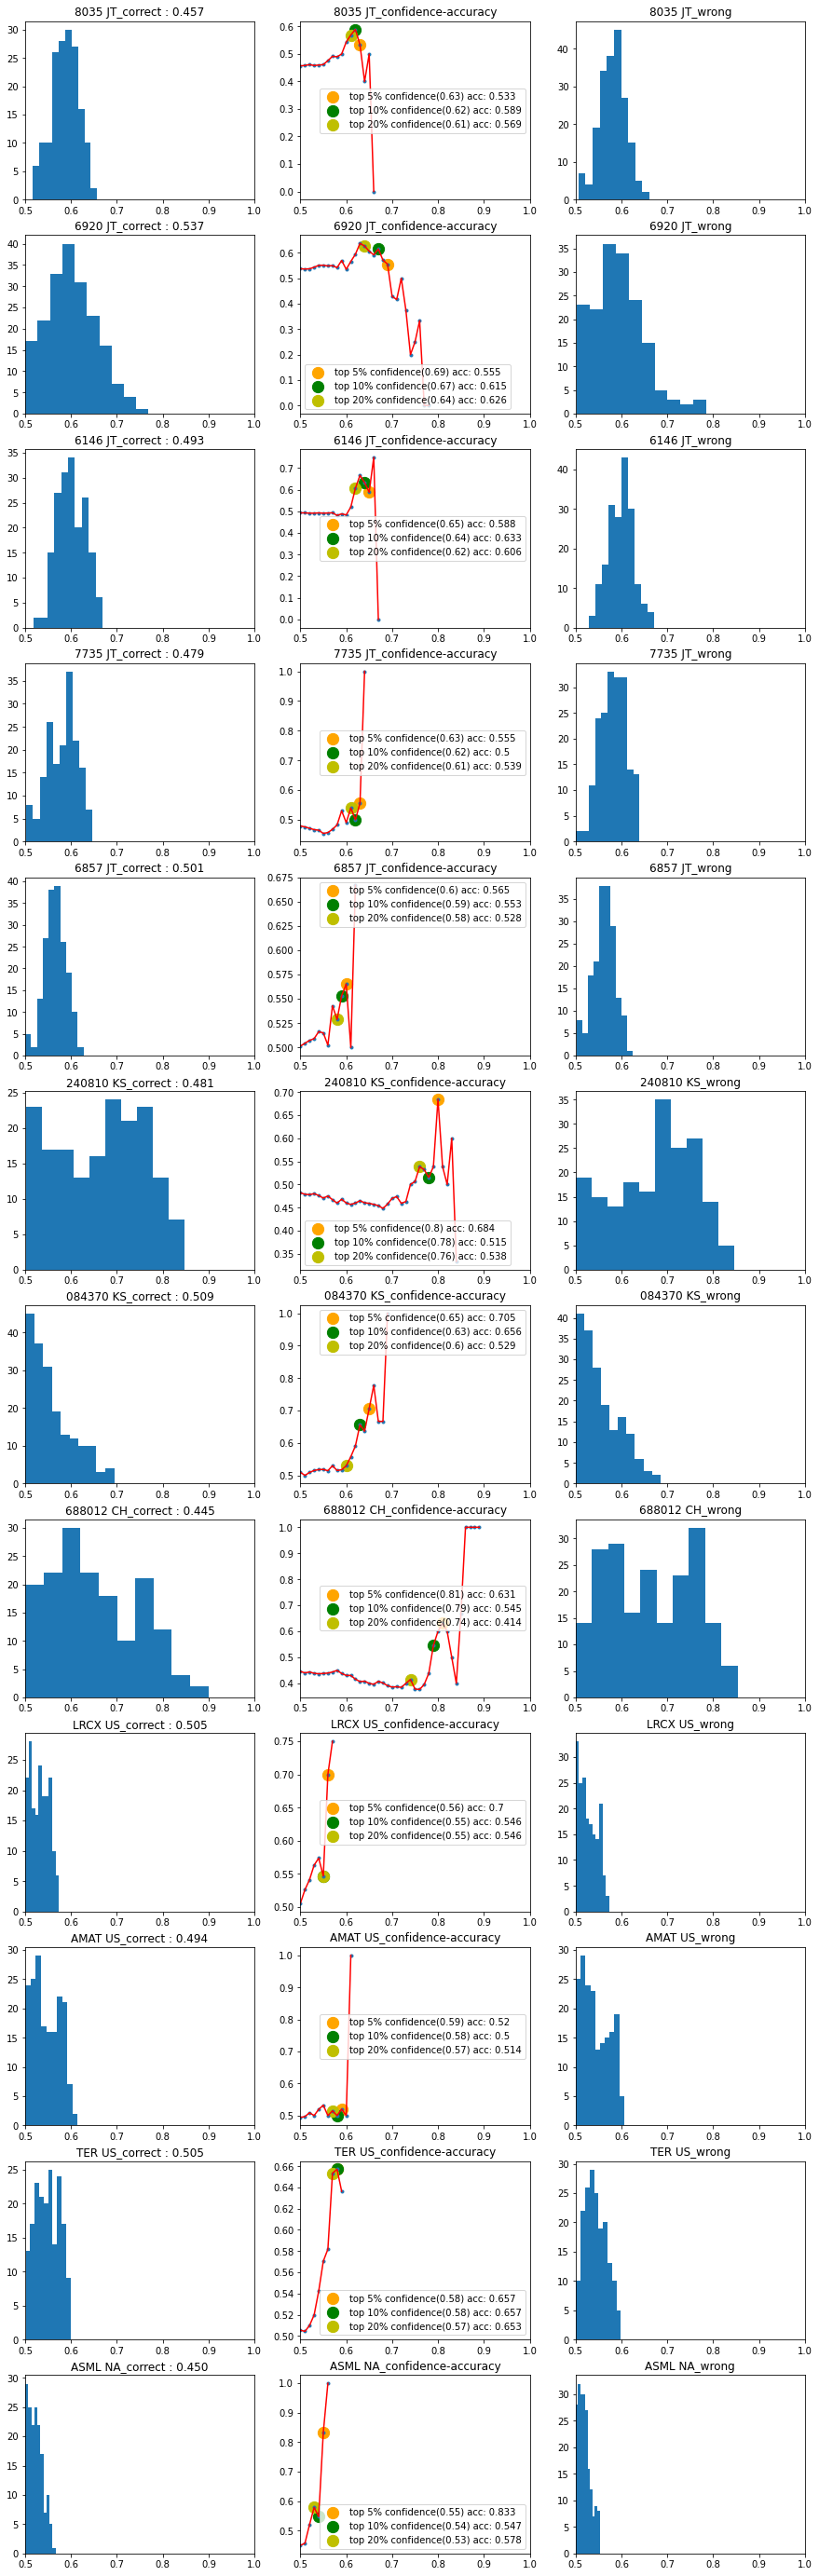

In [19]:
plots = get_conf_plots(whole2)
fig, ax = plt.subplots(12,3, figsize=(15,50))


for idx, name in enumerate(plots.keys()):
    plot_t, plot_f, acc, accs, thres = plots[name]
    
    # ----------------------
    thresacc = {}
    for i, _ac in enumerate(accs):
        thresacc[float(str(thres[i])[:4])] = _ac
    
    fp = len(plot_t) // 20 * (-1)
    tenp = len(plot_t) // 10 * (-1)
    ttwnp = len(plot_t) // 5 * (-1)
    plot_t_sorted = plot_t.copy()
    plot_t_sorted.sort()
    fp_thres = float(str(plot_t_sorted[fp])[:4])
    fpacc = thresacc[fp_thres]
    tenp_thres = float(str(plot_t_sorted[tenp])[:4])
    tenpacc = thresacc[tenp_thres]
    ttwnp_thres = float(str(plot_t_sorted[ttwnp])[:4])
    ttwnpacc = thresacc[ttwnp_thres]
    
    # ----------------------
    ax[idx][0].hist(plot_t)
    ax[idx][0].set_title(f'{name}_correct : {str(acc)[:5]}')
    ax[idx][0].set_xlim([0.5,1.0])
    ax[idx][1].plot(thres, accs, '.')
    ax[idx][1].plot(thres, accs, color='r')
    ax[idx][1].set_title(name+'_confidence-accuracy')
    
    ax[idx][1].scatter(fp_thres, fpacc, c='orange', s=150, label=f'top 5% confidence({fp_thres}) acc: {str(fpacc)[:5]}')
    ax[idx][1].scatter(tenp_thres, tenpacc, c='g', s=150, label=f'top 10% confidence({tenp_thres}) acc: {str(tenpacc)[:5]}')
    ax[idx][1].scatter(ttwnp_thres, ttwnpacc, c='y', s=150, label=f'top 20% confidence({ttwnp_thres}) acc: {str(ttwnpacc)[:5]}')
    ax[idx][1].legend()

    ax[idx][1].set_xlim([0.5,1.0])
    
    ax[idx][2].hist(plot_f)
    ax[idx][2].set_title(name+'_wrong')
    ax[idx][2].set_xlim([0.5,1.0])

    
save_name = 'confidence_interval'
plt.savefig(save_name + '.jpg')




In [ ]:
conf = {}
conf_acc1= {}
conf_acc2= {}

for name in whole_f.keys():
    equity = whole_f[name]
    equity2 = whole2_f[name]
    
    conf[name] = {'88':0, '87':0,'86':0, '85':0, '78':0,'77':0,'76':0, '75':0,'68':0,'67':0,'66':0, '65':0, '55':0}
    conf_acc1[name] = {'88a1':0, '87a1':0,'86a1':0, '85a1':0, '78a1':0,'77a1':0,'76a1':0, '75a1':0,'68a1':0,'67a1':0,'66a1':0, '65a1':0, '55a1':0}
    conf_acc2[name] = {'88a2':0, '87a2':0,'86a2':0, '85a2':0, '78a2':0,'77a2':0,'76a2':0, '75a2':0,'68a2':0,'67a2':0,'66a2':0, '65a2':0, '55a2':0}

    for date in equity.keys():
        if date == '20210928':
            continue
        _, _, correct1, a8_1, a7_1, a6_1, a5_1 = equity[date]
        
        next_date = next_dict[date]
        _, _, correct2, a8_2, a7_2, a6_2, a5_2 = equity2[next_date]

        conf[name]['88'] += 1 if (a8_1 and a8_2) else 0
        conf_acc1[name]['88a1'] += 1 if correct1 and (a8_1 and a8_2) else 0
        conf_acc2[name]['88a2'] += 1 if correct2 and (a8_1 and a8_2) else 0

        conf[name]['87'] += 1 if (a8_1 and a7_2) else 0
        conf_acc1[name]['87a1'] += 1 if correct1 and (a8_1 and a7_2) else 0
        conf_acc2[name]['87a2'] += 1 if correct2 and (a8_1 and a7_2) else 0

        conf[name]['86'] += 1 if (a8_1 and a6_2) else 0
        conf_acc1[name]['86a1'] += 1 if correct1 and (a8_1 and a6_2) else 0
        conf_acc2[name]['86a2'] += 1 if correct2 and (a8_1 and a6_2) else 0

        conf[name]['85'] += 1 if (a8_1 and a5_2) else 0
        conf_acc1[name]['85a1'] += 1 if correct1 and (a8_1 and a5_2) else 0
        conf_acc2[name]['85a2'] += 1 if correct2 and (a8_1 and a5_2) else 0


        conf[name]['78'] += 1 if (a7_1 and a8_2) else 0
        conf_acc1[name]['78a1'] += 1 if correct1 and (a7_1 and a8_2) else 0
        conf_acc2[name]['78a2'] += 1 if correct2 and (a7_1 and a8_2) else 0

        conf[name]['77'] += 1 if (a7_1 and a7_2) else 0
        conf_acc1[name]['77a1'] += 1 if correct1 and (a7_1 and a7_2) else 0
        conf_acc2[name]['77a2'] += 1 if correct2 and (a7_1 and a7_2) else 0
        
        conf[name]['76'] += 1 if (a7_1 and a6_2) else 0
        conf_acc1[name]['76a1'] += 1 if correct1 and (a7_1 and a6_2) else 0
        conf_acc2[name]['76a2'] += 1 if correct2 and (a7_1 and a6_2) else 0
        
        conf[name]['75'] += 1 if (a7_1 and a5_2) else 0
        conf_acc1[name]['75a1'] += 1 if correct1 and (a7_1 and a5_2) else 0
        conf_acc2[name]['75a2'] += 1 if correct2 and (a7_1 and a5_2) else 0
        
        conf[name]['68'] += 1 if (a6_1 and a8_2) else 0
        conf_acc1[name]['68a1'] += 1 if correct1 and (a6_1 and a8_2) else 0
        conf_acc2[name]['68a2'] += 1 if correct2 and (a6_1 and a8_2) else 0
        
        conf[name]['67'] += 1 if (a6_1 and a7_2) else 0
        conf_acc1[name]['67a1'] += 1 if correct1 and (a6_1 and a7_2) else 0
        conf_acc2[name]['67a2'] += 1 if correct2 and (a6_1 and a7_2) else 0
        
        conf[name]['66'] += 1 if (a6_1 and a6_2) else 0
        conf_acc1[name]['66a1'] += 1 if correct1 and (a6_1 and a6_2) else 0
        conf_acc2[name]['66a2'] += 1 if correct2 and (a6_1 and a6_2) else 0

        conf[name]['65'] += 1 if (a6_1 and a5_2) else 0
        conf_acc1[name]['65a1'] += 1 if correct1 and (a6_1 and a5_2) else 0
        conf_acc2[name]['65a2'] += 1 if correct2 and (a6_1 and a5_2) else 0

        
        conf[name]['55'] += 1 if (a5_1 and a5_2) else 0
        conf_acc1[name]['55a1'] += 1 if correct1 and (a5_1 and a5_2) else 0
        conf_acc2[name]['55a2'] += 1 if correct2 and (a5_1 and a5_2) else 0


for name in conf.keys():
    
    print('===')
    print(name)
    print(conf[name])
    for key in conf[name].keys():
        if conf[name][key] != 0:
            conf_acc1[name][key+'a1'] = conf_acc1[name][key+'a1'] / conf[name][key]
            conf_acc2[name][key+'a2'] = conf_acc2[name][key+'a2'] / conf[name][key]

        else:
            conf_acc1[name][key+'a1'] = 0
            conf_acc2[name][key+'a2'] = 0


    x = []
    y = []
    x2 = []
    y2 = []
    fig, ax = plt.subplots()
    '''
    for k, v in conf[name].items():
        x.append(k)
        y.append(v)
        
    
    plt.scatter(x,y)
    ax.set_title(name)
    ax.set_ylim([0,400])
    '''

    for k, v in conf_acc1[name].items():
        x.append(k[:2])
        y.append(v)
        
    plt.scatter(x,y, label='t+1')
    ax.set_title(name)
    ax.set_ylim([0,1.1])
    
    for k, v in conf_acc2[name].items():
        x2.append(k[:2])
        y2.append(v)
    plt.scatter(x2,y2, color='r', label='t+2')
    plt.legend()
    


    print(conf_acc1[name])
    print(conf_acc2[name])
    print('===')



In [ ]:
print(stats2)
acc_sum = 0
for idx, key in enumerate(stats2.keys()):
    print('====')
    print(key)
    stat = stats2[key]
    acc_sum += stat['acc']
    print(f"정확도: {stat['acc']}%")
    print(f"80%: 비율: {stat['08']}% - 정확도: {stat['08_acc']}%")
    print(f"70%: 비율: {stat['07']}% - 정확도: {stat['07_acc']}%")
    print(f"60%: 비율: {stat['06']}% - 정확도: {stat['06_acc']}%")

    print('====')
print(acc_sum / (idx+1))

In [ ]:
img_dir = '/home/nas1_temp/junhahyung/trading/imgs'
for name in plots.keys():
    fig, ax = plt.subplots(10,1, figsize=(100,100))
    x, y, pc, p8, p7, p6,_ = plots[name]
    length = len(x)
    div = length // 10
    for i in range(10):
        _x = x[div*i:div*(i+1)]
        _y = y[div*i:div*(i+1)]
        _pc = pc[div*i:div*(i+1)]
        _p8 = p8[div*i:div*(i+1)]
        _p7 = p7[div*i:div*(i+1)]
        _p6 = p6[div*i:div*(i+1)]

        ax[i].plot(_x,_y)
        _xc = []
        _yc = []
        for idx, c in enumerate(_pc):
            if c:
                _xc.append(_x[idx])
                _yc.append(_y[idx])
        _x8 = []
        _y8 = []
        for idx, c in enumerate(_p8):
            if c:
                _x8.append(_x[idx])
                _y8.append(_y[idx])
        _x7 = []
        _y7 = []
        for idx, c in enumerate(_p7):
            if c:
                _x7.append(_x[idx])
                _y7.append(_y[idx])
        
        _x6 = []
        _y6 = []
        for idx, c in enumerate(_p6):
            if c:
                _x6.append(_x[idx])
                _y6.append(_y[idx])
                
        ax[i].scatter(_xc, _yc, color='red')
        ax[i].scatter(_x8, _y8, facecolors='none', edgecolors='r', s=300)
        ax[i].scatter(_x7, _y7, facecolors='none', edgecolors='g', s=600)
        ax[i].scatter(_x6, _y6, facecolors='none', edgecolors='b', s=900)

        every_nth = 10
        for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
   
        ax[i].set_title(name+'_'+str(i))
    
    save_name = os.path.join(img_dir, name)
    plt.savefig(save_name + '.jpg')
        

In [ ]:
x = ['5','10', '15', '20', '25', '30']
y = [0.5735694766044617, 0.5686003565788269, 0.5613912343978882, 0.5163352489471436, 0.5432276725769043,0.5433723330497742]

fig, ax = plt.subplots()
plt.plot(x,y)
ax.set_ylim([0.5,0.6])

ax.set_title('t+1 predict')


In [ ]:
with open('summary_all.txt') as fp:
    lines = fp.readlines()
length = len(lines) // 4

ret = {}
for i in range(length):
    acc = float(lines[4*i+1].split(' ')[-1][:-2])
    name = lines[4*i].split()[0]
    print(name)
    ret[name] = acc

x = []
y = []
for i in range(1,51):
    
    name = 'target'+str(i)
    
    try:
        y.append(ret[name])

        x.append(i)
    except:
        pass
    


fig, ax = plt.subplots()
plt.scatter(x,y)
ax.set_ylim([0.5,0.7])

ax.set_title('ntarget predict')
